In [67]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
sigma = 1
beta = 5
rho = 20

# Define initial condition
def fun_u_0():
    return 1,1,1

# Define residual of the PDE
def fun_r1(x_t,x,y):
    return x_t - sigma*(y-x)

def fun_r2(y_t,x,y,z):
    return y_t - x * (rho - z) +y
def fun_r3(z_t,x,y,z):
    return z_t - x*y - beta*z

def fun_r(x_t,y_t,z_t,x,y,z):
    return fun_r1(x_t,x,y) + fun_r2(y_t,x,y,z) + fun_r3(z_t,x,y,z)

In [68]:
#设置时间轴采样点的数量
N_r = 10000

#设置求解区域（这里只能是时间）
tmin = 0
tmax = 100

tf.random.set_seed(0)

#采点
#初始时刻只有一个点（因为这使用时间来预测空间点的lorenz正问题）
t_0 = 0
x_0,y_0,z_0 = fun_u_0()
#求解区域内部
t_r = tf.random.uniform((N_r,1),tmin,tmax,dtype=DTYPE)

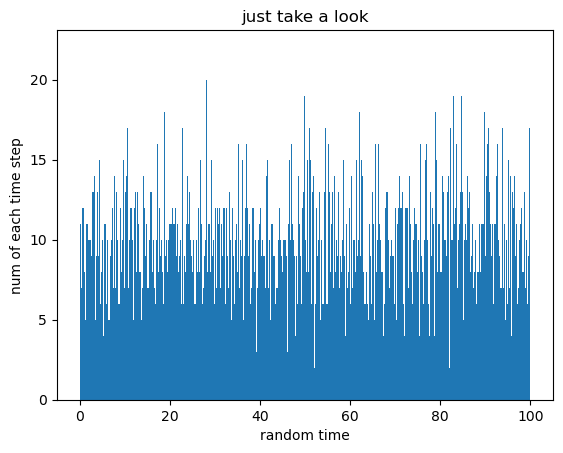

In [69]:
import matplotlib.pyplot as plt
plt.hist(t_r.numpy(), bins=1000, range=(tmin, tmax))
plt.xlabel('random time')
plt.ylabel('num of each time step')
plt.title('just take a look')
plt.show()

In [70]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(1))

    # Introduce a scaling layer to map input to [tmin, tmax]
    scaling_layer = tf.keras.layers.Lambda(
                lambda t: 2.0*(t - tmin)/(tmax - tmin) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(3))

    return model

In [71]:
def get_r(model,t_r):
    with tf.GradientTape(persistent=True) as tape:
        t = t_r
        tape.watch(t)

        x,y,z = model(t)

        x_t = tape.gradient(x,t)
        y_t = tape.gradient(y,t)
        z_t = tape.gradient(z,t)

    del tape

    return fun_r(x_t,y_t,z_t,x,y,z)
        
     

In [74]:
def compute_loss(model,t_r,t_0,x_0,y_0,z_0):
    # Compute phi^r
    r = get_r(model, t_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r    

    #Add initial loss to the phi^r
    x_pred,y_pred,z_pred = model(t_0)
    loss +=tf.reduce_mean(tf.square(x_0 - x_pred) + tf.square(y_0 - y_pred) + tf.square(z_0 - z_pred))

    return loss

In [ ]:
def get_grad(model,X_r,t_0,x_0,y_0,z_0)